In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds

!pip3 install pyspellchecker
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from textblob import Word

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.3 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [3]:
# # Path to input folder
# input_path = './kaggle/input/feedback-prize-english-language-learning/'
# all_files = os.listdir(input_path)
# files = []
# for file in all_files:
#     if file.endswith('.csv'):
#         files.append(file)
# files

In [4]:
# Read 'train.csv' dataset and preview
raw_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
raw_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [5]:
# Get summary statistics
raw_df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Overview of raw data

In [6]:
# Check raw data
print('Number of reviews:', raw_df.shape[0])
print('Unique cohesion values:', np.sort(raw_df.cohesion.unique()))
print('Unique syntax values:', np.sort(raw_df.syntax.unique()))
print('Unique vocabulary values:', np.sort(raw_df.vocabulary.unique()))
print('Unique phraseology values:', np.sort(raw_df.phraseology.unique()))
print('Unique grammar values:', np.sort(raw_df.grammar.unique()))
print('Unique conventions values:', np.sort(raw_df.conventions.unique()))

Number of reviews: 3911
Unique cohesion values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique syntax values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique vocabulary values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique phraseology values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique grammar values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique conventions values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


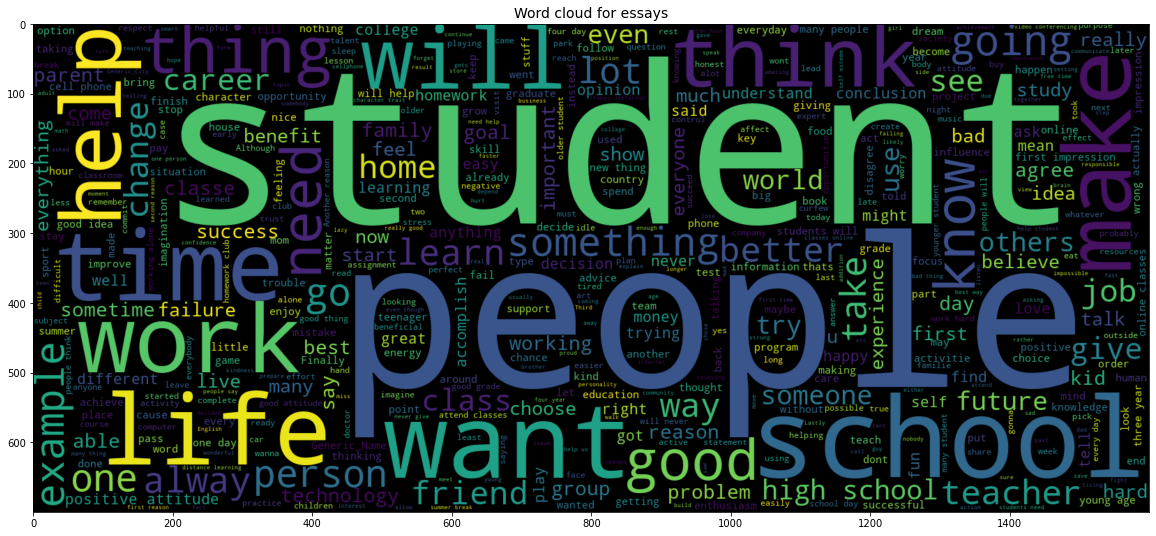

In [7]:
# Create a word cloud
plt.figure(figsize = (20,10))
wc = WordCloud(
    max_words = 500,
    width = 1600,
    height = 700).generate(" ".join(raw_df.full_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for essays',fontsize=14);

## Feature Engineering

Before doing any feature engineering, split the data 60/40 (train/validate)

In [8]:
# copy the raw data
df = raw_df.copy(deep=True)

# create train and validation set splits
df_train = df.sample(frac=0.6, random_state=1)
df_validate = df.drop(df_train.index)

print('train', df_train.shape[0])
print('validate', df_validate.shape[0])
print('train + validate', df_train.shape[0] + df_validate.shape[0])
print('original', df.shape[0])

train 2347
validate 1564
train + validate 3911
original 3911


Get an idea of essay lengths in the training data set

In [9]:
# check max and min lengths of essays
max_length = max(len(x.split()) for x in df_train['full_text'])
min_length = min(len(x.split()) for x in df_train['full_text'])

# calculate average length of essays
total_words = 0
for essay in df_train['full_text']:
    total_words += len(essay.split())
avg_length = total_words / df_train.shape[0]

print(f'longest essay has {max_length} words')
print(f'shortest essay has {min_length} words')
print(f'average essay has {avg_length:.0f} words')

longest essay has 1260 words
shortest essay has 14 words
average essay has 431 words


## **New Feature**: Repeated Word Count

In [10]:
def get_repeated_words(text):
    text_freq = WordCloud().process_text(text)
    repeated_words = dict((k, v) for k, v in text_freq.items() if v > 1)
    return repeated_words

def count_repeated_words(repeated_words_dict):
    number_of_repeated_words = len(repeated_words_dict)
    return number_of_repeated_words

def most_repeated_word(repeated_words_dict):
    max_word = max(repeated_words_dict, key=repeated_words_dict.get)
    return max_word

def count_most_repeated_word(repeated_words_dict, max_word):
    max_word_freq = repeated_words_dict[max_word]
    return max_word_freq

# add columns for words that are repeated more than once and the most repeated word
df_train['number_repeated_words'] = df_train.apply(lambda row: count_repeated_words(get_repeated_words(row['full_text'])), axis=1)
df_train['most_repeated_word'] = df_train.apply(lambda row: most_repeated_word(get_repeated_words(row['full_text'])), axis=1)
df_train['most_repeated_word_count'] = df_train.apply(lambda row: count_most_repeated_word(get_repeated_words(row['full_text']), most_repeated_word(get_repeated_words(row['full_text']))), axis=1)

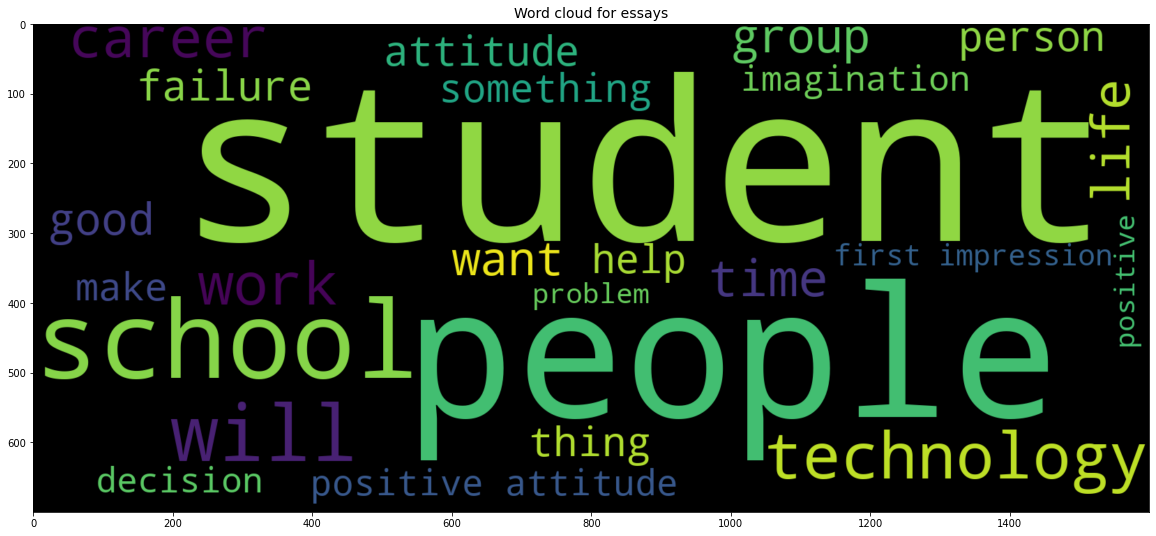

In [11]:
# Create a word cloud with the top 25 most repeated words
plt.figure(figsize = (20,10))
wc = WordCloud(
    max_words = 25,
    width = 1600,
    height = 700).generate(" ".join(df_train['most_repeated_word']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for essays',fontsize=14);

## **New Features**: Word Count & Average Word Length

In [12]:
# word counts and average word length
df_train['word_count'] = df_train['full_text'].map(lambda x:len(x.split()))
df_train['avg_word_len'] = df_train['full_text'].map(lambda x: np.mean([len(w) for w in str(x).split()]))
avg_word_len = round(np.mean(df_train['avg_word_len']))
print('Average Word Length: {}'.format(avg_word_len))

Average Word Length: 4


## **New Features**: Sentence Count & Average Sentence Length

In [13]:
df_train['sent_count'] = df_train['full_text'].apply(lambda x: len(sent_tokenize(x)))
avg_sent = round(df_train['sent_count'].mean())
print('Average Sentence Count: {}'.format(avg_sent))

df_train['avg_sent_len'] = df_train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
avg_sent_len = round(np.mean(df_train['avg_sent_len']))
print('Average Sentence Length: {}'.format(avg_sent_len))

Average Sentence Count: 18
Average Sentence Length: 30


## **New Feature**: Stop Word Count

In [14]:
# count no. of stop words
stop_words = set(stopwords.words('english'))
df_train['stopwords_count'] = df_train['full_text'].str.split().apply(lambda x: len(set(x) & stop_words))
df_train['stopwords_pct'] = df_train['stopwords_count']/df_train['word_count']

## **New Feature**: Spelling Error Count

In [15]:
# In order to check for spelling  errors, punctuation from contractions (e.g. won't, can't, etc.) must first be converted

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"he/she", "he or she", phrase)
    return phrase

# clean text for spell checking
def clean_punc(text):
    text = text.lower()
    #foction de replacement
    text = decontracted(text)
    text = re.sub(r"[^A-Za-z0-9]+"," ",text)
    return text

# instantiate SpellChecker class object
spell = SpellChecker()

# create a new column with count of spell_errors and count of spell_errors
df_train['text_wo_punc'] = [clean_punc(w) for w in df_train['full_text']]

# calculate the spelling errors
df_train['spell_error'] = df_train['text_wo_punc'].apply(lambda x: spell.unknown(word_tokenize(x)))
df_train['spell_error_count'] = df_train['spell_error'].str.len()

In [16]:
# summary of table with 9 additional features
df_train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,number_repeated_words,most_repeated_word_count,word_count,avg_word_len,sent_count,avg_sent_len,stopwords_count,stopwords_pct,spell_error_count
count,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000
mean,3.129527,3.021304,3.236472,3.115467,3.025138,3.082233,34.608436,13.309757,430.826161,4.342111,18.256498,30.213740,46.874308,0.121434,3.943332
std,0.663288,0.648769,0.583138,0.655883,0.702879,0.667773,15.128536,6.525437,191.633325,0.296113,10.263402,28.231806,11.205625,0.037145,5.830347
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,14.000000,3.325879,1.000000,6.344828,0.000000,0.000000,0.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,24.000000,9.000000,293.000000,4.145501,10.000000,18.465041,39.000000,0.095825,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,32.000000,12.000000,405.000000,4.336609,17.000000,23.235294,47.000000,0.115473,2.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,43.000000,17.000000,531.000000,4.520489,24.000000,33.141667,54.000000,0.139725,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,99.000000,64.000000,1260.000000,5.440964,99.000000,578.000000,87.000000,0.428571,86.000000


In [17]:
# display final dataframe
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,number_repeated_words,most_repeated_word,most_repeated_word_count,word_count,avg_word_len,sent_count,avg_sent_len,stopwords_count,stopwords_pct,text_wo_punc,spell_error,spell_error_count
2149,A0B2BF94231C,First impressions are almost impossible to cha...,4.0,3.5,3.5,4.0,3.5,4.0,24,person,19,421,4.733967,31,13.580645,43,0.102138,first impressions are almost impossible to cha...,"{coversation, truely, isnt, wost, mintutes}",5
953,48F7FCAD8B23,Will has you can see getting advice from other...,3.0,3.0,3.5,3.0,2.0,2.0,55,people,20,764,3.982984,25,30.560000,62,0.081152,will has you can see getting advice from other...,{},0
2315,AC8331539332,"""Do we choose our own character traits, or our...",2.5,3.5,3.5,3.5,2.5,3.0,56,people,11,659,4.376328,22,29.954545,64,0.097117,do we choose our own character traits or our ...,{},0
2026,98D8FF9E3C56,"The life is being more modern, people also nee...",4.5,3.5,4.0,3.5,3.0,3.5,59,students,16,602,4.576412,37,16.270270,59,0.098007,the life is being more modern people also need...,{tv},1
921,46D16CB314CD,People often use a good attitudes to successed...,3.5,4.0,3.5,3.0,2.5,3.0,24,help,15,306,4.313725,18,17.000000,38,0.124183,people often use a good attitudes to successed...,"{timein, prombles, succesed, chorse, successed...",13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,E0B4FCC6FD58,I feel like best way is working with a group i...,3.0,2.5,3.0,3.0,3.5,3.0,22,group,13,275,3.810909,4,68.750000,44,0.160000,i feel like best way is working with a group i...,"{convestions, respone, opionion, internt}",4
488,25248BD3EEC2,Can your attitude be the key to success in lif...,3.5,4.0,3.5,3.5,3.5,3.5,18,attitude,10,204,4.759804,14,14.571429,35,0.171569,can your attitude be the key to success in lif...,{},0
1124,573E39E45177,"Is distance learning such as, online learning ...",3.0,3.0,3.5,2.5,2.5,3.0,42,learning,11,471,4.857749,25,18.840000,54,0.114650,is distance learning such as online learning o...,"{tradtional, techonolgy, negaitive, techonolog...",7
3035,D93895A285B0,It is not a good idea for student to graduate ...,3.0,3.0,3.5,3.5,3.0,4.0,29,high school,10,443,4.069977,10,44.300000,44,0.099323,it is not a good idea for student to graduate ...,{},0


## Data Visualization

Measures are the categories over which each essay was scored. <br>
Features are the individual measurable characteristics of each essay. <br>
Each measure is assigned a color for the plots below.

In [18]:
measure_list = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

feature_list = ['number_repeated_words', 'most_repeated_word_count', 'word_count', 'avg_word_len',
                'sent_count', 'avg_sent_len', 'stopwords_count', 'spell_error_count']

color_list = ['red', 'orange', 'green', 'blue', 'purple', 'brown']

## Create box-and-whisker plots to visualize outliers and distribution of essays scores in terms of created feature vs measure score

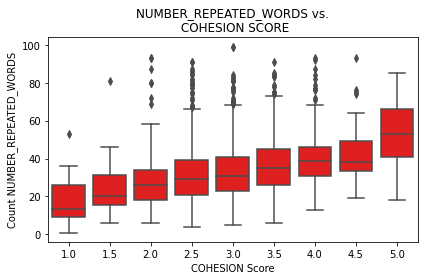

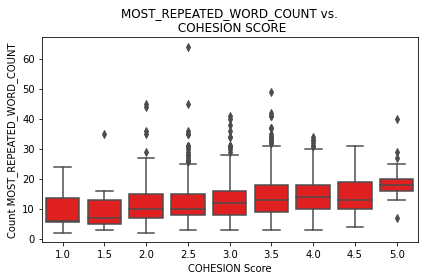

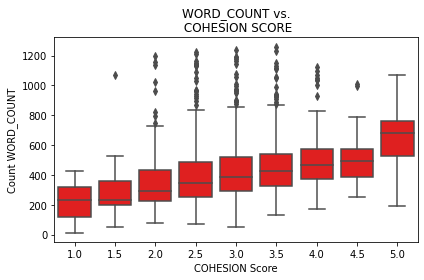

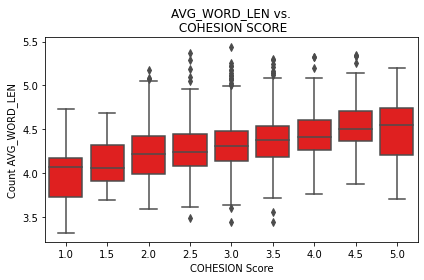

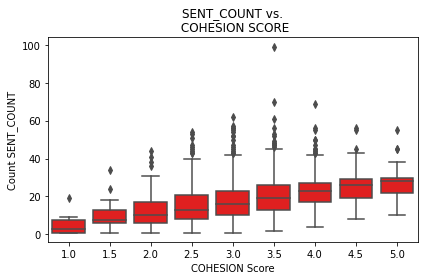

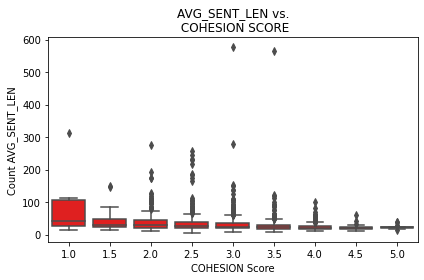

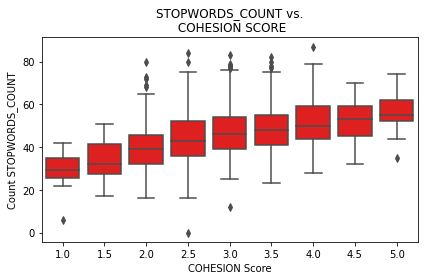

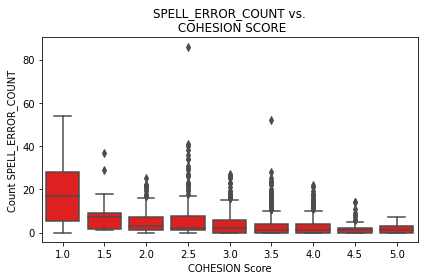

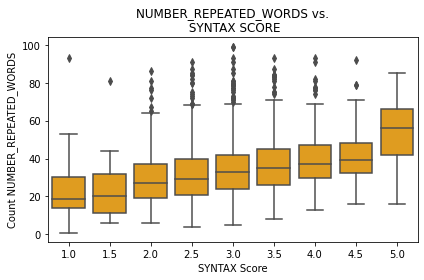

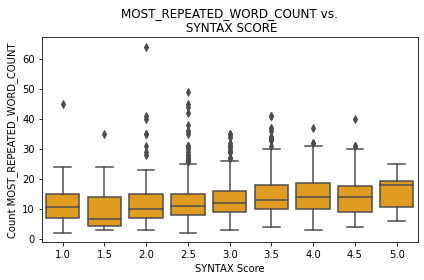

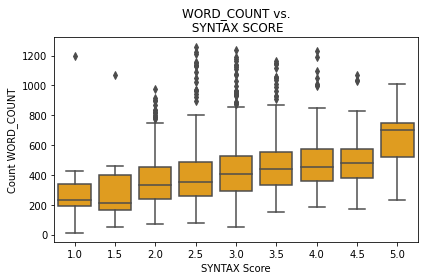

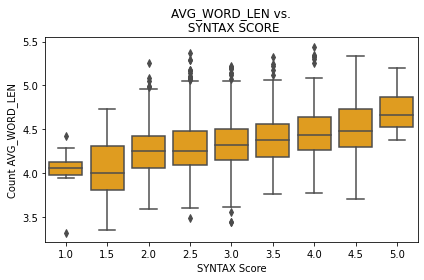

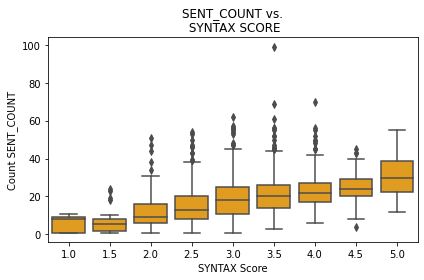

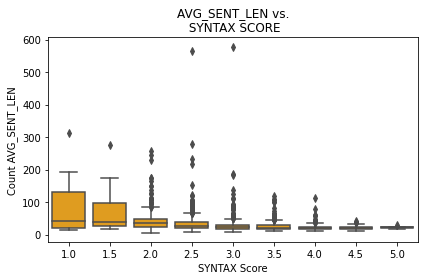

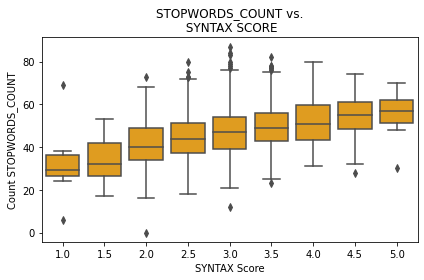

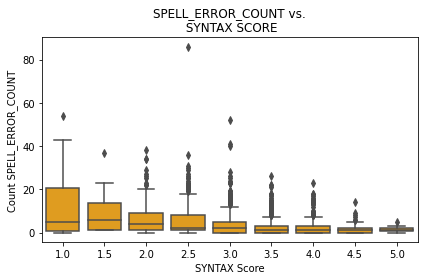

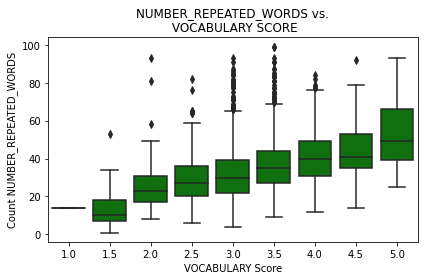

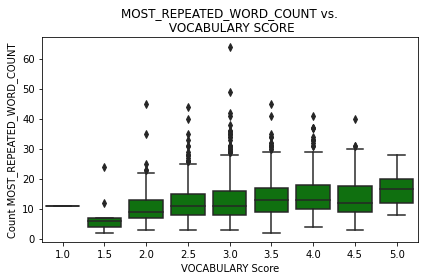

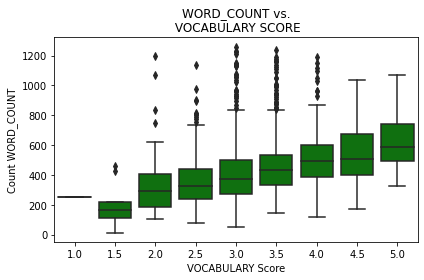

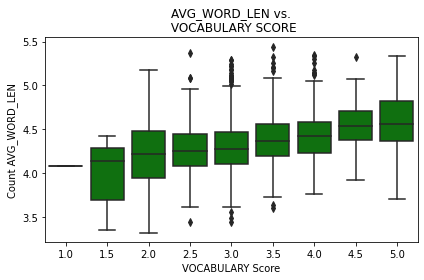

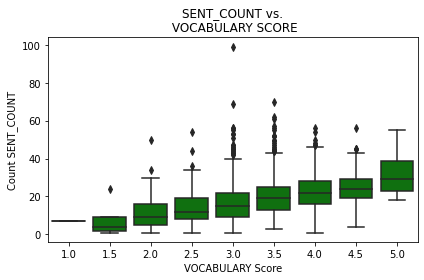

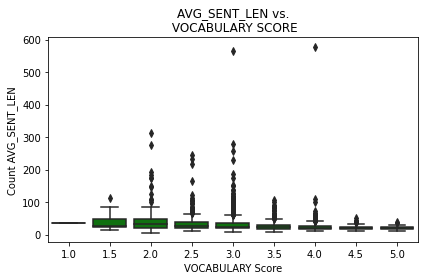

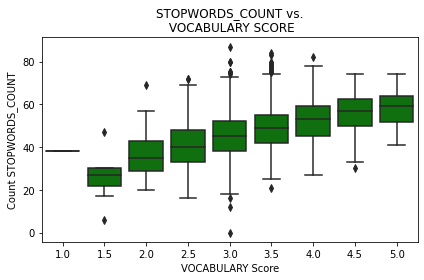

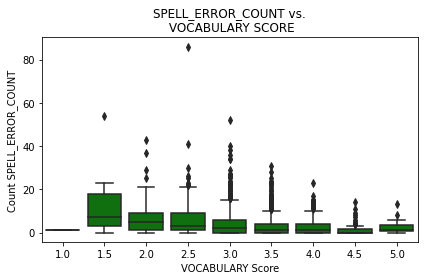

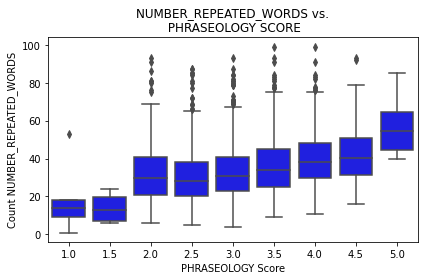

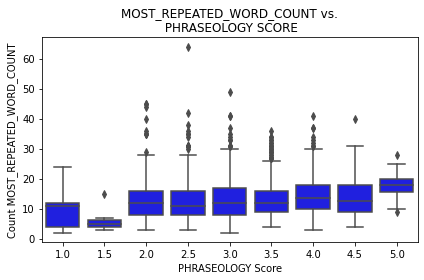

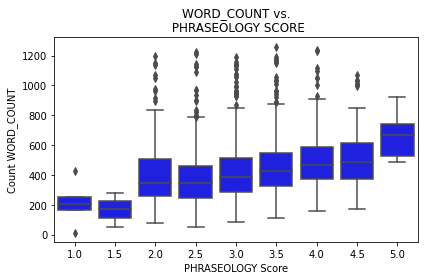

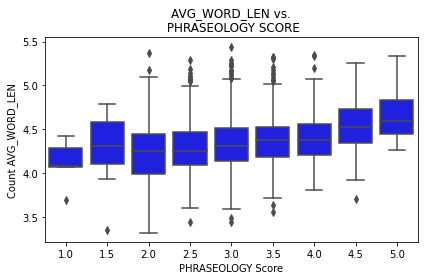

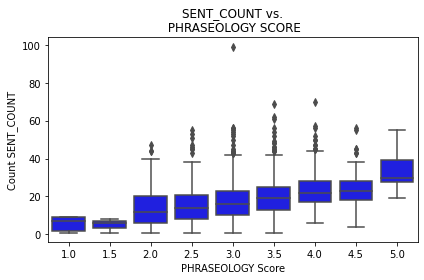

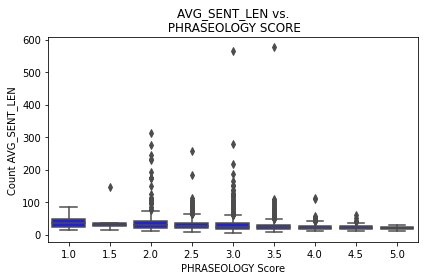

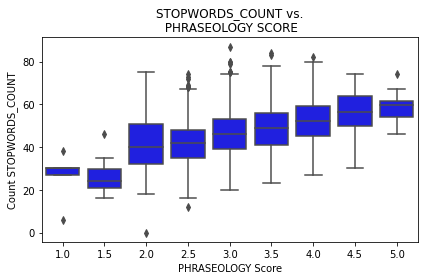

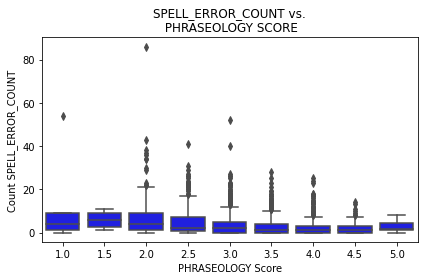

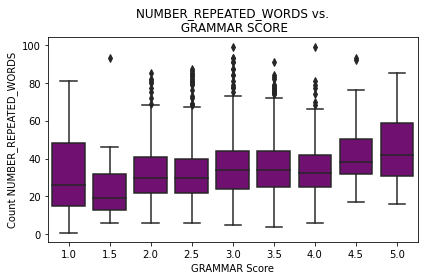

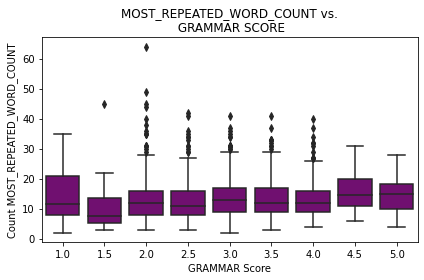

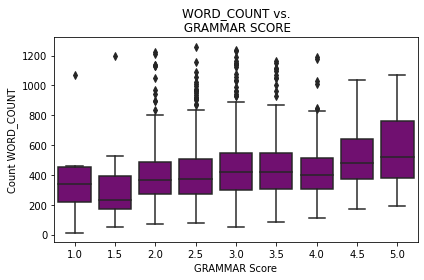

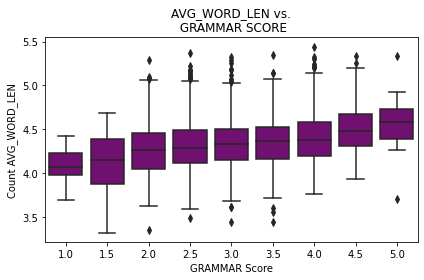

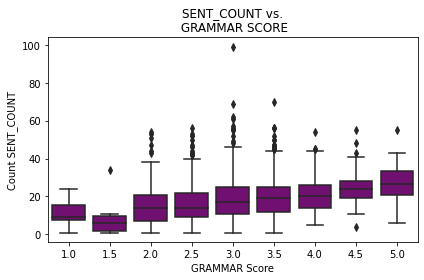

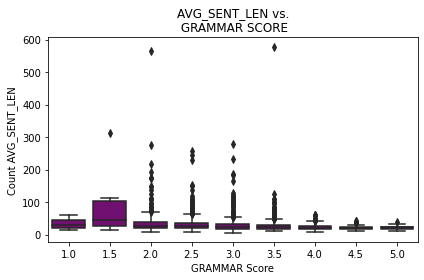

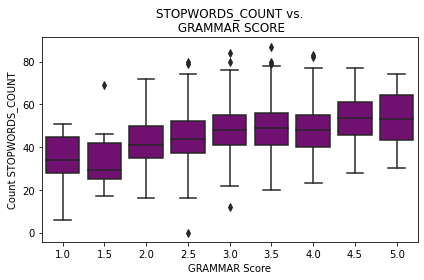

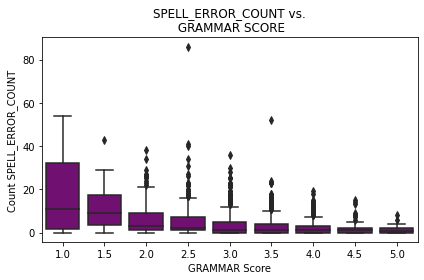

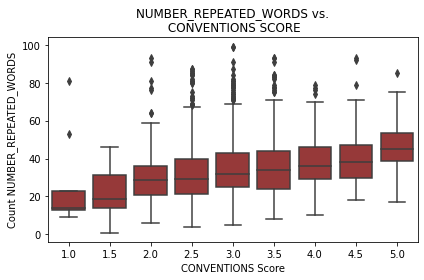

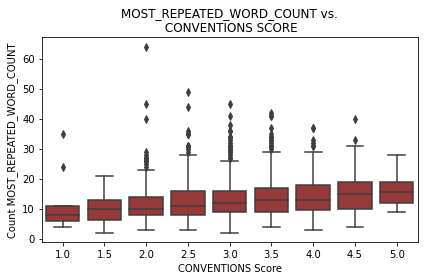

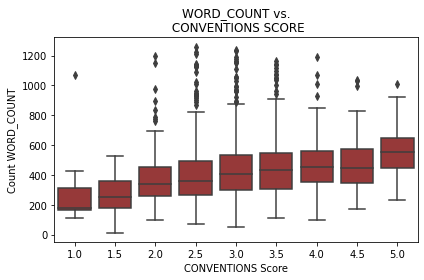

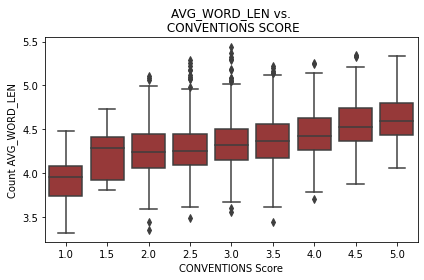

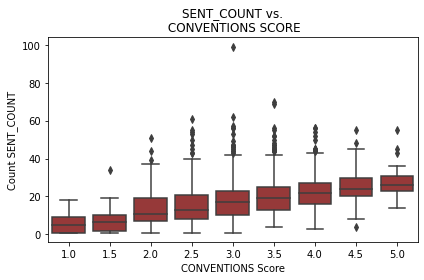

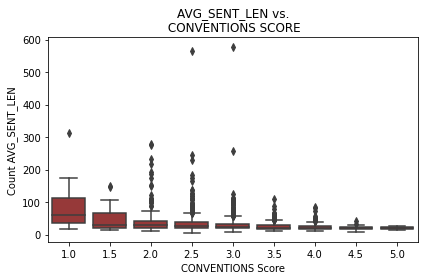

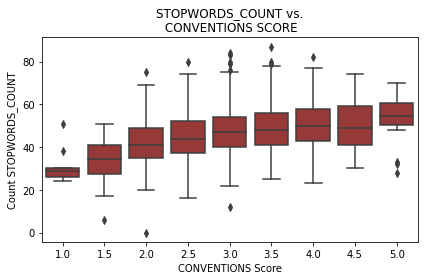

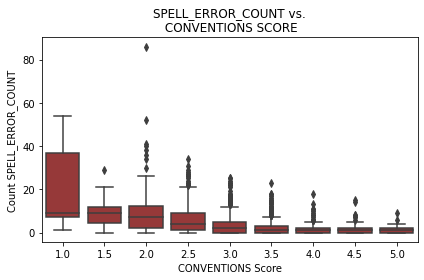

In [19]:
# create a function to box-and-whisker plot a new feature against a score measure
def box_whisker_plot_feature_vs_measure(df, feature, measure, color):
    
    # plot a bar chart to visualize distribution
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[measure], y=df[feature], data=pd.melt(df), color=color)
    plt.xlabel(f'{measure.upper()} Score')
    plt.ylabel(f'Count {feature.upper()}')
    plt.title(f'{feature.upper()} vs.\n {measure.upper()} SCORE')
    plt.tight_layout()
    plt.show()
    
    return

# loop through and create a scatter plot for each measure and each feature
for i in range(len(measure_list)):
    for feature in feature_list:
        box_whisker_plot_feature_vs_measure(df_train, feature, measure_list[i], color_list[i])

## Examine correlation between measures and new features

In [20]:
# correlation matrix with the new features
df_train.corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,number_repeated_words,most_repeated_word_count,word_count,avg_word_len,sent_count,avg_sent_len,stopwords_count,stopwords_pct,spell_error_count
cohesion,1.000000,0.697872,0.666860,0.690914,0.633024,0.657299,0.248885,0.168143,0.232681,0.253911,0.343476,-0.197115,0.307925,-0.199077,-0.188348
syntax,0.697872,1.000000,0.676503,0.730997,0.702000,0.697971,0.225489,0.139704,0.216980,0.237787,0.364552,-0.254698,0.314409,-0.149820,-0.228668
vocabulary,0.666860,0.676503,1.000000,0.733237,0.648729,0.661285,0.311034,0.141377,0.292315,0.246976,0.344008,-0.162669,0.388770,-0.189764,-0.208189
phraseology,0.690914,0.730997,0.733237,1.000000,0.727389,0.669064,0.241002,0.098305,0.229503,0.192425,0.309929,-0.165430,0.366664,-0.124980,-0.202108
grammar,0.633024,0.702000,0.648729,0.727389,1.000000,0.667405,0.119260,0.041656,0.105378,0.179148,0.233804,-0.176332,0.242560,-0.027078,-0.222921
conventions,0.657299,0.697971,0.661285,0.669064,0.667405,1.000000,0.176372,0.123765,0.169048,0.252093,0.316103,-0.232704,0.245391,-0.118998,-0.379915
number_repeated_words,0.248885,0.225489,0.311034,0.241002,0.119260,0.176372,1.000000,0.507119,0.933409,0.009121,0.648216,0.011429,0.738199,-0.730008,0.135762
most_repeated_word_count,0.168143,0.139704,0.141377,0.098305,0.041656,0.123765,0.507119,1.000000,0.588066,0.176336,0.440421,0.013260,0.301285,-0.603873,0.037053
word_count,0.232681,0.216980,0.292315,0.229503,0.105378,0.169048,0.933409,0.588066,1.000000,-0.074450,0.648380,0.059236,0.769819,-0.764913,0.133769
avg_word_len,0.253911,0.237787,0.246976,0.192425,0.179148,0.252093,0.009121,0.176336,-0.074450,1.000000,0.134748,-0.208358,-0.096930,-0.019888,-0.097196


In [21]:
# get high correlation feature pairs
# code from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# any correlations above 0.7 and below -0.7 are shown
corrFilter(df_train, .7)

stopwords_pct          word_count              -0.764913
number_repeated_words  stopwords_pct           -0.730008
syntax                 grammar                  0.702000
phraseology            grammar                  0.727389
syntax                 phraseology              0.730997
vocabulary             phraseology              0.733237
number_repeated_words  stopwords_count          0.738199
word_count             stopwords_count          0.769819
                       number_repeated_words    0.933409
cohesion               cohesion                      NaN
dtype: float64

From the correlation matrix and filter above, the top three highest correlations are:
- word_count and number_repeated_words
- word_count and stopwords_count
- number_repeated_words and stopwords_count

**Conclusions** <br>
Word length, average word length and sentence count have a positive relationship with the score
- Average sentence length, % of stopwords, % of word spell error and % of repeated words have negative relationship with the score
- Vocabulary has higher correlation with word count and spell error
- Syntax has higher correlation with sentence count and average sentence length, as well as % of repeated words
- Cohesion has higher correlation with average word length and % of stopwords
- Phraseology has higher correlation with % of repeated words

In [22]:
# Export final dataframe to .csv
df_train.to_csv('train_new_features')